# Лабораторная работа 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from io import StringIO
from scipy import stats
from scipy.stats import skew, kurtosis, t, chi2

import math

# -----------------------------
# 1. Исходные данные
# -----------------------------
data_str = '''Region Alcohol Tobacco
North 6.47 4.03
Yorkshire 6.13 3.76
Northeast 6.19 3.77
East_Midlands 4.89 3.34
West_Midlands 5.63 3.47
East_Anglia 4.52 2.92
Southeast 5.89 3.20
Southwest 4.79 2.71
Wales 5.27 3.53
Scotland 6.08 4.51
Northern_Ireland 4.02 4.56
London 7.20 3.90
South_East 5.95 3.45
North_West 5.45 3.25
Midlands 5.10 3.15
West_Country 4.85 2.95
East_England 5.70 3.60
Central 4.50 3.10
South_West 4.75 3.05
North_East 5.55 3.35
East_Yorkshire 5.40 3.25
West_Yorkshire 5.25 3.30
Northern_Scotland 6.30 4.20
Southern_Scotland 6.15 4.10
'''

df = pd.read_csv(StringIO(data_str), sep=r'\s+')
df.head()


,Region,Alcohol,Tobacco
0,North,6.47,4.03
1,Yorkshire,6.13,3.76
2,Northeast,6.19,3.77
3,East_Midlands,4.89,3.34
4,West_Midlands,5.63,3.47


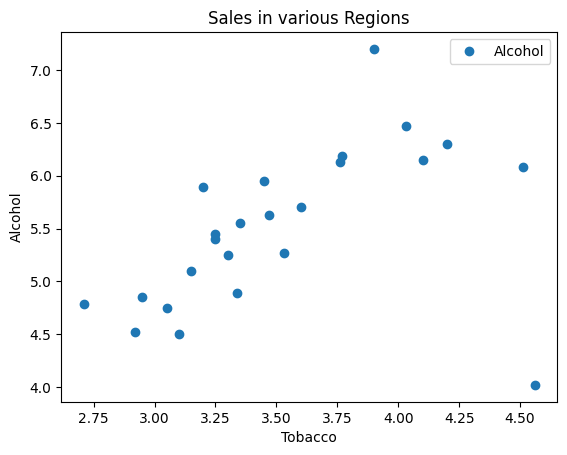

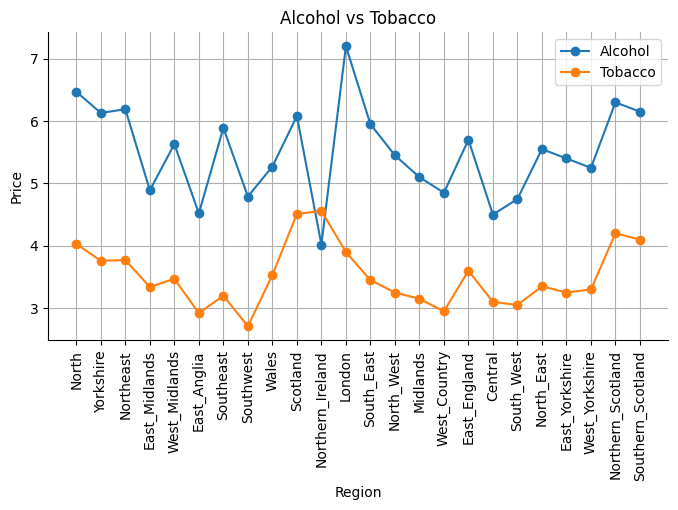

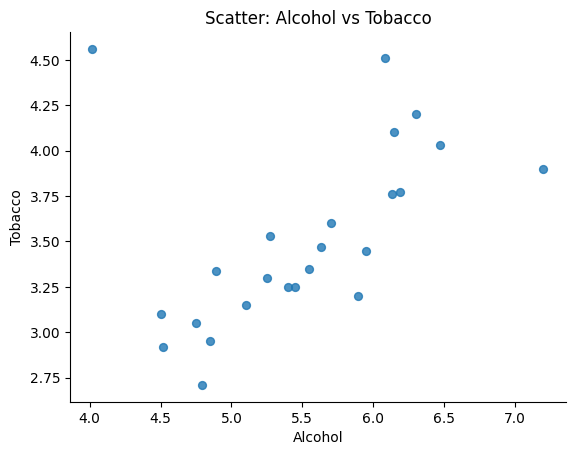

In [2]:
# -----------------------------
# 2. Визуализация
# -----------------------------

# (а) простое облако точек Alcohol от Tobacco
df.plot('Tobacco', 'Alcohol', style='o')
plt.ylabel('Alcohol')
plt.title('Sales in various Regions')
plt.show()

# (б) Alcohol vs Tobacco по регионам (линейный график)
df.plot(style='o-', figsize=(8, 4), title='Alcohol vs Tobacco')
plt.grid()
plt.xticks(range(len(df)), labels=df['Region'], rotation=90)
plt.xlabel('Region')
plt.ylabel('Price')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# (в) scatter Alcohol–Tobacco
df.plot(kind='scatter', x='Alcohol', y='Tobacco', s=32, alpha=.8)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Scatter: Alcohol vs Tobacco')
plt.show()


In [3]:
# -----------------------------
# 3. Линейная регрессия
#    3.1. Библиотечная (для сравнения)
# -----------------------------
result_lib = smf.ols('Alcohol ~ Tobacco', df).fit()
print(result_lib.summary())


                            OLS Regression Results                            
Dep. Variable:                Alcohol   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     5.959
Date:                Tue, 23 Dec 2025   Prob (F-statistic):             0.0232
Time:                        20:36:44   Log-Likelihood:                -23.651
No. Observations:                  24   AIC:                             51.30
Df Residuals:                      22   BIC:                             53.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0507      1.013      3.011      0.0

In [4]:
# -----------------------------
# 3.2. Матричная реализация OLS
# -----------------------------

# Вектор y и матрица X (столбец единиц + Tobacco)
y = df['Alcohol'].values             # (n,)
x = df['Tobacco'].values             # (n,)
n = len(y)

X = np.column_stack([np.ones(n), x]) # (n, 2)
k_plus_1 = X.shape[1]                # число параметров (β0 + β1)
k = k_plus_1 - 1                     # число признаков

# β = (X^T X)^(-1) X^T y
XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
Xty = X.T @ y
beta = XtX_inv @ Xty               # [β0, β1]

beta_0, beta_1 = beta

print("Коэффициенты β (ручной расчёт):")
print("Intercept =", beta_0)
print("Tobacco   =", beta_1)

print("\nКоэффициенты β (statsmodels):")
print(result_lib.params)


Коэффициенты β (ручной расчёт):
Intercept = 3.050749281457768
Tobacco   = 0.6964122823565867

Коэффициенты β (statsmodels):
Intercept    3.050749
Tobacco      0.696412
dtype: float64


In [5]:
# -----------------------------
# 4. Предсказания, остатки, суммы квадратов
# -----------------------------
y_hat = X @ beta                  # предсказанные значения
resid = y - y_hat                 # остатки

SSR = np.sum(resid**2)            # Sum of Squared Residuals
SST = np.sum((y - y.mean())**2)   # Total Sum of Squares
SSM = np.sum((y_hat - y.mean())**2)  # Model Sum of Squares

print(f"SSR = {SSR:.4f}, SST = {SST:.4f}, SSM = {SSM:.4f}")


SSR = 10.0852, SST = 12.8167, SSM = 2.7315


In [6]:
# -----------------------------
# 5. R² и скорректированный R²
# -----------------------------
R2 = SSM / SST
R2_adj = 1 - (1 - R2) * (n - 1) / (n - k_plus_1)

print("R² (ручной расчёт):      ", R2)
print("R² (statsmodels):        ", result_lib.rsquared)
print("\nAdj. R² (ручной расчёт):", R2_adj)
print("Adj. R² (statsmodels):   ", result_lib.rsquared_adj)


R² (ручной расчёт):       0.21312056624098147
R² (statsmodels):         0.21312056624098752

Adj. R² (ручной расчёт): 0.1773533192519351
Adj. R² (statsmodels):    0.17735331925194153


In [7]:
# -----------------------------
# 6. F-статистика для модели
# -----------------------------
DFM = k                # df_model
DFR = n - k_plus_1     # df_resid

MSM = SSM / DFM
MSE = SSR / DFR

F_value = MSM / MSE
p_F = 1 - stats.f.cdf(F_value, DFM, DFR)

print("F-statistic (ручной расчёт):", F_value)
print("p-value(F) (ручной расчёт): ", p_F)
print("\nF-statistic (statsmodels):  ", result_lib.fvalue)
print("Prob(F) (statsmodels):      ", result_lib.f_pvalue)


F-statistic (ручной расчёт): 5.958539842505946
p-value(F) (ручной расчёт):  0.023154114650050128

F-statistic (statsmodels):   5.958539842506114
Prob(F) (statsmodels):       0.023154114650048418


In [8]:
# -----------------------------
# 7. Log-Likelihood, AIC, BIC
# -----------------------------
sigma2 = MSE

LogL = np.log(
    (1.0 / np.sqrt(2 * np.pi * sigma2))**n *
    np.exp(-SSR / (2 * sigma2))
)

AIC = 2 * k_plus_1 - 2 * LogL
BIC = k_plus_1 * np.log(n) - 2 * LogL

print("Log-Likelihood (ручной расчёт):", LogL)
print("Log-Likelihood (statsmodels):  ", result_lib.llf)

print("\nAIC (ручной расчёт):", AIC)
print("AIC (statsmodels):   ", result_lib.aic)

print("\nBIC (ручной расчёт):", BIC)
print("BIC (statsmodels):   ", result_lib.bic)


Log-Likelihood (ручной расчёт): -23.694805468156442
Log-Likelihood (statsmodels):   -23.650668944280888

AIC (ручной расчёт): 51.389610936312884
AIC (statsmodels):    51.301337888561775

BIC (ручной расчёт): 53.745718597008775
BIC (statsmodels):    53.657445549257666


In [9]:
# -----------------------------
# 8. Ковариационная матрица, SE, t, p-value
# -----------------------------
# cov(β) = σ² (X^T X)^(-1)
cov_beta = sigma2 * XtX_inv
se_beta = np.sqrt(np.diag(cov_beta))

t_stats = beta / se_beta
p_vals = 2 * stats.t.sf(np.abs(t_stats), df=DFR)

print("Стандартные ошибки (ручной расчёт):", se_beta)
print("Стандартные ошибки (statsmodels):   ", result_lib.bse.values)

print("\n t-статистики (ручной расчёт):", t_stats)
print(" t-статистики (statsmodels):   ", result_lib.tvalues.values)

print("\n p-value (ручной расчёт):", p_vals)
print(" p-value (statsmodels):   ", result_lib.pvalues.values)


Стандартные ошибки (ручной расчёт): [1.0133559  0.28529654]
Стандартные ошибки (statsmodels):    [1.0133559  0.28529654]

 t-статистики (ручной расчёт): [3.0105408  2.44101205]
 t-статистики (statsmodels):    [3.0105408  2.44101205]

 p-value (ручной расчёт): [0.0064354  0.02315411]
 p-value (statsmodels):    [0.0064354  0.02315411]


In [10]:
# -----------------------------
# 9. Доверительные интервалы для β
# -----------------------------
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df=DFR)

CI_manual = np.column_stack([
    beta - t_crit * se_beta,
    beta + t_crit * se_beta
])

print("CI (ручной расчёт):")
print("Intercept:", CI_manual[0])
print("Tobacco:  ", CI_manual[1])

print("\nCI (statsmodels):")
print(result_lib.conf_int())


CI (ручной расчёт):
Intercept: [0.94917777 5.15232079]
Tobacco:   [0.10474348 1.28808108]

CI (statsmodels):
                  0         1
Intercept  0.949178  5.152321
Tobacco    0.104743  1.288081


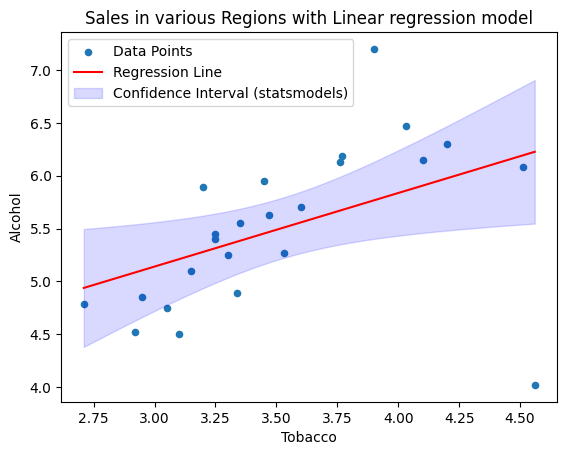

In [11]:
# -----------------------------
# 10. Визуализация: линия регрессии + доверительная полоса
# -----------------------------
fig, ax = plt.subplots()
df.plot('Tobacco', 'Alcohol', kind='scatter', ax=ax, label='Data Points')
plt.ylabel('Alcohol')
plt.title('Sales in various Regions with Linear regression model')

x_line = np.linspace(df['Tobacco'].min(), df['Tobacco'].max(), 100)
y_line = beta_0 + beta_1 * x_line
plt.plot(x_line, y_line, color='red', label='Regression Line')

# для наглядности CI по библиотечной модели (линейка та же)
pred = result_lib.get_prediction(pd.DataFrame({'Tobacco': x_line}))
ci = pred.conf_int(alpha=0.05)
plt.fill_between(x_line, ci[:, 0], ci[:, 1], color='blue', alpha=0.15,
                 label='Confidence Interval (statsmodels)')

plt.legend()
plt.show()


Skewness (ручной расчёт): -1.175890518637792
Kurtosis (ручной расчёт): 6.80600279682061

Skewness (scipy): -1.1758905186377568
Kurtosis (scipy*2, как в тетрадке): 7.612005593641106


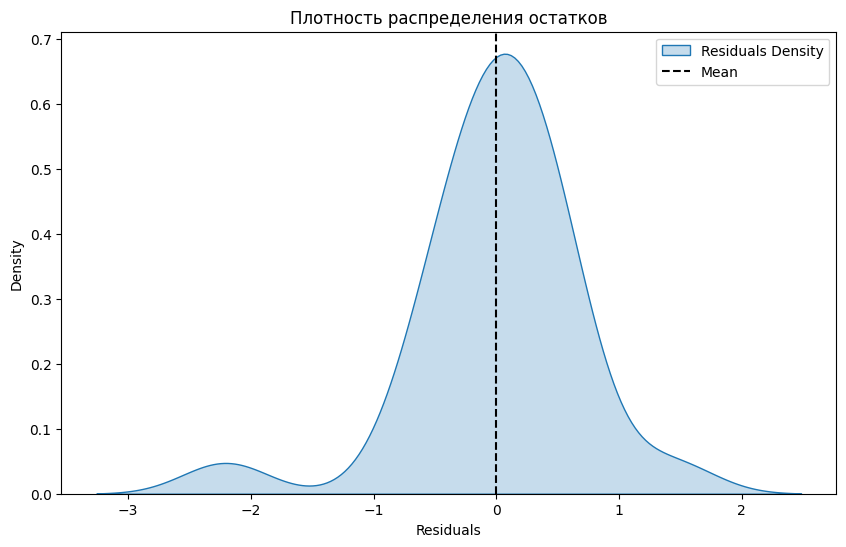


Omnibus (ручной расчёт): 14.913900626983008 p-value: 0.0005774144220407587
Omnibus (statsmodels):    14.913900626983462 p-value: 0.0005774144220406278

Durbin–Watson (ручной расчёт): 2.4027091239740894
Durbin–Watson (statsmodels):    2.4027091239740863

JB (ручной расчёт): 20.016531336695326 p-value: 4.502621562629816e-05
JB (statsmodels):   20.01653133669564 p-value: 4.502621562632345e-05

Condition Number (ручной расчёт): 28.072385850857998
Condition Number (statsmodels):   28.072385850858936


In [12]:
# -----------------------------
# 11. Анализ остатков: Skewness, Kurtosis, Omnibus, DW, JB, CN
# -----------------------------
# Skewness и Kurtosis (ручной расчёт через формулы и сравнение с scipy)
S_manual = np.mean(resid**3) / np.mean(resid**2)**(3/2)
K_manual = np.mean(resid**4) / np.mean(resid**2)**2

print("Skewness (ручной расчёт):", S_manual)
print("Kurtosis (ручной расчёт):", K_manual)

print("\nSkewness (scipy):", skew(resid))
print("Kurtosis (scipy*2, как в тетрадке):", kurtosis(resid)*2)

# Плотность остатков
plt.figure(figsize=(10, 6))
sns.kdeplot(resid, fill=True, label='Residuals Density')
plt.axvline(x=0, color='black', linestyle='--', label='Mean')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Плотность распределения остатков')
plt.legend()
plt.show()

# Omnibus / normaltest
K2_manual, p_omni_manual = stats.normaltest(resid)
from statsmodels.stats.stattools import omni_normtest
K2_sm, p_omni_sm = omni_normtest(result_lib.resid)

print("\nOmnibus (ручной расчёт):", K2_manual, "p-value:", p_omni_manual)
print("Omnibus (statsmodels):   ", K2_sm, "p-value:", p_omni_sm)

# Durbin–Watson
DW_manual = np.sum(np.diff(resid)**2) / SSR
from statsmodels.stats.stattools import durbin_watson
DW_sm = durbin_watson(result_lib.resid)

print("\nDurbin–Watson (ручной расчёт):", DW_manual)
print("Durbin–Watson (statsmodels):   ", DW_sm)

# Jarque–Bera
S = S_manual
K = K_manual
JB_manual = (n/6.0) * (S**2 + 0.25 * (K - 3)**2)
p_JB_manual = 1 - chi2(df=2).cdf(JB_manual)

from statsmodels.stats.stattools import jarque_bera
JB_sm, p_JB_sm, _, _ = jarque_bera(result_lib.resid)

print("\nJB (ручной расчёт):", JB_manual, "p-value:", p_JB_manual)
print("JB (statsmodels):  ", JB_sm, "p-value:", p_JB_sm)

# Condition Number
X_design = X
XTX = X_design.T @ X_design
EV = np.linalg.eigvals(XTX)
CN_manual = np.sqrt(EV.max() / EV.min())

print("\nCondition Number (ручной расчёт):", CN_manual)
print("Condition Number (statsmodels):  ", np.linalg.cond(result_lib.model.exog))


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.datasets import load_diabetes

plt.style.use('default')

# Загружаем датасет diabetes
diab = load_diabetes(as_frame=True)
df2 = diab.frame.copy()   # здесь уже есть таргет 'target'

print("Форма датасета (строки, столбцы):", df2.shape)
display(df2.head())

print("\nОписание числовых столбцов:")
display(df2.describe())


Форма датасета (строки, столбцы): (442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0



Описание числовых столбцов:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


In [14]:
# Проверка пропусков в каждом столбце
print("Число пропусков в каждом столбце:")
print(df2.isna().sum())

# Если бы были пропуски — пример заполнения медианой
df2_filled = df2.copy()
for col in ['bmi', 'bp', 's5']:
    df2_filled[col] = df2_filled[col].fillna(df2_filled[col].median())


Число пропусков в каждом столбце:
age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


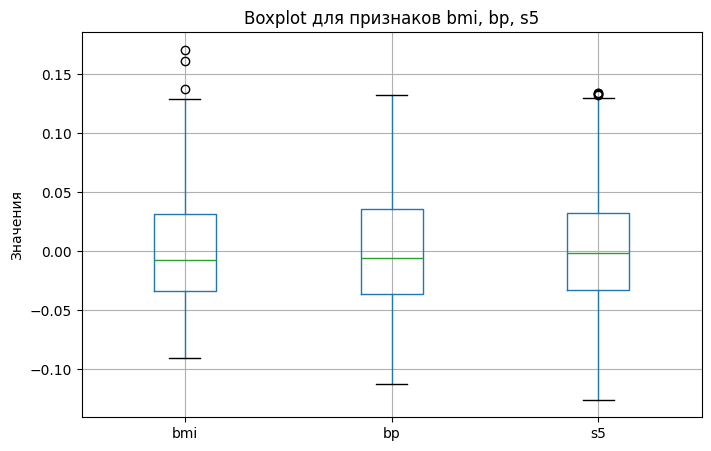


Признак: bmi
 Нижняя граница: -0.13244469328909578
 Верхняя граница: 0.1294636406639386
 Число потенциальных выбросов: 3

Признак: bp
 Нижняя граница: -0.14510588681465247
 Верхняя граница: 0.14409359515668546
 Число потенциальных выбросов: 0

Признак: s5
 Нижняя граница: -0.1317624678553964
 Верхняя граница: 0.13094919936371954
 Число потенциальных выбросов: 4


In [15]:
plt.figure(figsize=(8, 5))
df2[['bmi', 'bp', 's5']].boxplot()
plt.ylabel('Значения')
plt.title('Boxplot для признаков bmi, bp, s5')
plt.show()

# При желании можно вывести значения "усов" и возможных выбросов по формуле 1.5 * IQR
for col in ['bmi', 'bp', 's5']:
    q1 = df2[col].quantile(0.25)
    q3 = df2[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df2[(df2[col] < lower) | (df2[col] > upper)][col]
    print(f"\nПризнак: {col}")
    print(" Нижняя граница:", lower)
    print(" Верхняя граница:", upper)
    print(" Число потенциальных выбросов:", len(outliers))


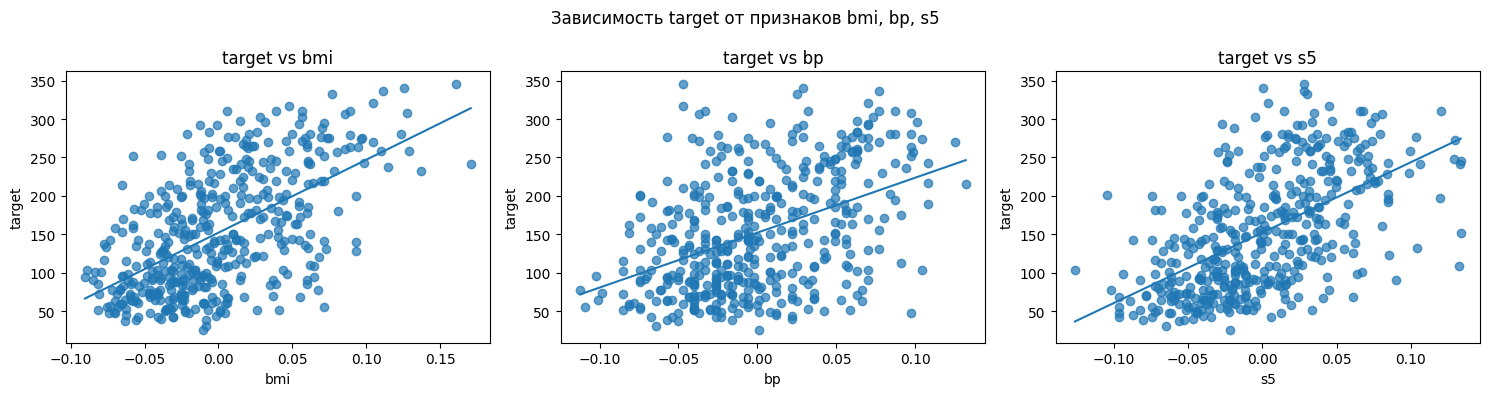

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

features = ['bmi', 'bp', 's5']
for ax, col in zip(axes, features):
    ax.scatter(df2[col], df2['target'], alpha=0.7)
    ax.set_xlabel(col)
    ax.set_ylabel('target')
    ax.set_title(f'target vs {col}')
    # простая линия регрессии для наглядности
    m, b = np.polyfit(df2[col], df2['target'], 1)
    x_line = np.linspace(df2[col].min(), df2[col].max(), 100)
    y_line = m * x_line + b
    ax.plot(x_line, y_line)

plt.suptitle('Зависимость target от признаков bmi, bp, s5')
plt.tight_layout()
plt.show()


In [17]:
# Строим модель множественной линейной регрессии
model = smf.ols('target ~ bmi + bp + s5', data=df2).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     134.8
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           7.16e-62
Time:                        20:36:45   Log-Likelihood:                -2402.6
No. Observations:                 442   AIC:                             4813.
Df Residuals:                     438   BIC:                             4830.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.1335      2.653     57.342      0.0

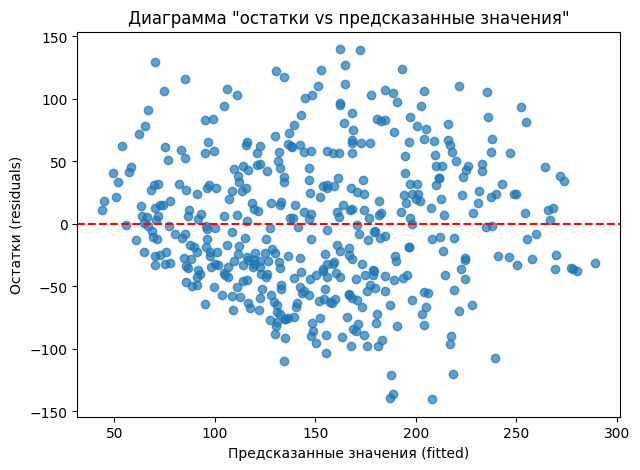

In [18]:
# Остатки и предсказания
residuals = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(7, 5))
plt.scatter(fitted, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения (fitted)')
plt.ylabel('Остатки (residuals)')
plt.title('Диаграмма "остатки vs предсказанные значения"')
plt.show()
